<a href="https://colab.research.google.com/github/arangoml/arangopipe/blob/master/examples/Arangopipe_Feature_Example_ext1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Intro**
In part 3 of the [Introduction to ArangoML series](https://www.arangodb.com/tag/arangoml/), we will take a look at what bootstrapping is and how it relates to determining bias-variance tradeoff and composition. We will dive into the concepts of these topics, leaving the heavily mathematical discussion to those who already offer great explanations for these topics(linked at the bottom). 

This post will:

* Provide insight into the goals of these concepts
* Demonstrate a basic example
* Showcase the ease of use with ArangoML

## **Bootstrapping**

In the [previous post](https://www.arangodb.com/2020/10/arangoml-part-2-basic-arangopipe-workflow/), we explored the basic arangopipe workflow and discussed the concept of model building. One concept briefly mentioned was grabbing a sample of the large dataset to use during our model building exercise. This data sampling is referred to as bootstrap sampling and is one approach for tackling big data. To explain, we will continue using the housing prices dataset from the previous post.

Bootstrapping is a statistical technique.  There are situations where we have limited data but are interested in estimating the behavior of a statistic. For example, we have a single dataset, and we are interested in estimating how a model we have developed would perform on datasets we encounter in the future. Bootstrapping can give us useful estimates in these situations. 

Imagine that our dataset either currently or will in the future contain millions of documents for houses. Having this many documents would mean that every time we wanted to run a test when building the model, it would take a long time to get a result. Not only would there be a considerable time requirement but not having an accurate test dataset to test the model against would result in a potentially less precise model when used against future data. Bootstrap sampling combines the need for precision with the ability to timely develop a model. 

The intuition with bootstrapping is that each sample of the dataset is similar. The validity of our estimates depends on how reasonable it is to assume that the samples are similar. In situations where there is limited variability in the data, this assumption can be reasonable. 

With bootstrapping, we generate reasonable proxies for these other samples by sampling the dataset that we have with replacement. Replacement is allowing for all of the same documents to be used in different sample sets. Rather than removing the document from the pool of data, often referred to as a population, when used in a sample, it is returned to the pool. Returning the document to the dataset means that everytime we make a new sample set we have the exact same probability for choosing each document, this helps ensure that each sample set is equally reflective of the entire population of data. 



# Installation Pre-requisites

In [ ]:
%%capture
!pip install python-arango
!pip install arangopipe==0.0.6.9.3
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip install seaborn
!pip install dtreeviz


In case you have not done the previous examples, here is a quick look at the dataset we are working with.

This dataset is available from the arangopipe repo and was originally made avaialble from the UCI ML Repository. The dataset contains data for housing in California, including:

* The house configuration & location
* The median house values and ages
* The general population & number of households
* The median income for the area

In [12]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/arangoml/arangopipe/arangopipe_examples/examples/data/cal_housing.csv"
df = pd.read_csv(data_url, error_bad_lines=False)
df.head()

,lat,long,housingMedAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500.0
1,-122.24,37.85,52,1467,190,496,177,7.2574,352100.0
2,-122.25,37.85,52,1274,235,558,219,5.6431,341300.0
3,-122.25,37.85,52,1627,280,565,259,3.8462,342200.0
4,-122.25,37.85,52,919,213,413,193,4.0368,269700.0


# Bias Variance Decompostion of Model Estimates

Once we have our sample datasets, we evaluate the model on these datasets and note its performance. The observed variation in performance is a proxy for the variation we are likely to observe with datasets in the future. In this example we apply the bootstrapping idea to estimate two important statistical qualities of the model we have developed. These are the bias and the variance of the model.

The bias of the model captures the errors resulting from incorrect assumptions about the model. In this example, we have used a linear regression model to estimate house prices. 
Some questions you may ask yourself: 
* Is linear regression too simple a model for this problem?  
* Do we need a more complex model? 
* Perhaps, for example, a polynomial regression model could be better? 

Examining the bias associated with the model can answer this question. Another source of the error associated with the model is its sensitivity to the training set. The error associated with sensitivity to the training set is the variance. Choosing a model with the right level of complexity is a critical modeling decision and involves balancing the bias and variance associated with the model. This is called the bias-variance tradeoff. 

**Note**: The intent of this explanation is to motivate the problem and the need for bootstrapping. For this reason, we have refrained from a rigorous mathematical definition of the bias and variance terms.

## Estimating the Bias at each point in the dataset

Evaluating the bias requires us to calculate the expected value (average) of the difference between the model estimate and the true value of the estimated quantity at each point of the dataset. In this example, this implies we need to evaluate the expected value of the difference between the model estimate and the true value of the house at each point. In calculating the expected value, we need to average over all datasets. This poses a problem because we only have a single dataset. How do we determine an average value of the deviation at this point? Bootstrapping is one way to solve this problem. For each point (house) in our dataset, we construct bootstrapped datasets that include the house. 

This method has a straightforward implementation; For each house in the dataset, construct a bootstrapped dataset that has that house, along with a random selection of other houses, from the dataset. Repeat this process to generate sufficient bootstrap datasets(NUM_BOOTSTRAPS in the code segment below).

In [13]:
from sklearn import linear_model
df['medianHouseValue'] = df['medianHouseValue'].apply(np.log)
preds = df.columns.tolist()
preds.remove('medianHouseValue')
SAMPLE_SIZE = 1000
df = df.sample(n = SAMPLE_SIZE)
df = df.reset_index()

NUM_BOOTSTRAPS = 30
BOOTSTRAP_SAMPLE_SIZE =  df.shape[0] - 1
bootstrap_Yest = {i : list() for i in range(df.shape[0])}
for index in range(df.shape[0]):
    for bootrap_iteration in range(NUM_BOOTSTRAPS):
        dfi = df.iloc[index, :]
        dfb = df.sample(n = BOOTSTRAP_SAMPLE_SIZE, replace=True)
        dfb = dfb.append(dfi)
        X = dfb[preds].values
        Y = dfb['medianHouseValue']

        clf = linear_model.Lasso(alpha=0.001, max_iter = 10000)
        clf.fit(X, Y)
        est_point = X[index, :].reshape(1, -1)
        est_at_index = clf.predict(est_point)
        bootstrap_Yest[index].append(est_at_index)
        
    if index % 100 == 0:
        print('Completed estimating %4d points in the dataset' % (index))

Completed estimating    0 points in the dataset
Completed estimating  100 points in the dataset
Completed estimating  200 points in the dataset
Completed estimating  300 points in the dataset
Completed estimating  400 points in the dataset
Completed estimating  500 points in the dataset
Completed estimating  600 points in the dataset
Completed estimating  700 points in the dataset
Completed estimating  800 points in the dataset
Completed estimating  900 points in the dataset


In [14]:
Xm = df[preds].values
Ym = df['medianHouseValue'].values
clf_0 = linear_model.Lasso(alpha=0.001, max_iter = 10000)
clf_0.fit(Xm, Ym)
Yhat_m = clf_0.predict(Xm)

In [15]:
# see section 2.2 from https://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf
# see https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf
Expval_at_i = { i : np.mean(np.array(bootstrap_Yest[i])) for i in range(df.shape[0])}
bias_at_i = {i : Expval_at_i[i] - Yhat_m[i] for i in range(df.shape[0])}


## Analysis of the Bias

We now have enough datasets that include the house at which we are interested in estimating the average deviation between the model and the truth. 
To calculate the average deviation:
* We now develop the model on each of the bootstrapped datasets 
* Then evaluate the difference between the truth and the model estimate
* We repeat this process for each bootstrap dataset
* Then average those quantities 

The average we end up with gives us the bootstrapped estimate of the bias at that point. It should be evident that the above procedure is computationally intensive. We generate bootstrap datasets that include each point and then we develop models on each of these datasets. For purposes of illustration, in this post, we will estimate the bias for a sample of the original dataset. 

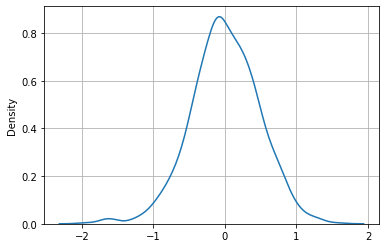

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
bias_values = [bias for (pt, bias) in bias_at_i.items()]
sns.kdeplot(bias_values)
plt.grid(True)

Examine a Kernel Density plot of the bias to see the range of values. 

Note:
The response is log transformed, so the bias must be exponeniated to get the real difference from the true value

In [17]:
from sklearn.cluster import KMeans
cluster_labels = KMeans(n_clusters=5, random_state=0).fit_predict(Xm)
cluster_labels.shape

(1000,)

After we have estimated the bias at each point, we can examine the bias values to see if there are systematic patterns in the bias. One simple evaluation technique to do this is to cluster the bias values.  If there are no systematic patterns then we should not see explicit clustering tendencies when we cluster the bias estimates. Dense clusters would indicate areas where our model is misspecified - either too much of complexity or not enough complexity.


To see where the model is making mistakes, we cluster the (sample of the) dataset and compute the average bias for each cluster. This provides insights into regions of the data space we are doing well (bias close to zero) and regions where we are not doing well. 

The table below shows the mean cluster bias and the size of the cluster. We see two large clusters where the bias is close to zero (cluster 0 and cluster 1). We see one outlier with a large error (cluster 3). Clusters 1 and 4 are also seem like outliers and need further analysis. 

This exercise illustrates how we can examine our model's characteristics. We can now link this model analysis activity to our project using Arangopipe.  

In [18]:
df_bias = pd.DataFrame(Xm)
df_bias['cluster'] = cluster_labels
df_bias['bias'] = bias_values
df_bias.groupby('cluster')['bias'].agg([np.mean, np.size])

,mean,size
cluster,,
0,0.061620,505.0
1,-0.275195,23.0
2,-0.111966,95.0
3,0.003068,2.0
4,-0.031035,375.0


## Storing in Arangopipe

Calculation of the variance can be performed analogously. Bias and variance are model characteristics that are of interest to data scientists because they convey information about its strengths, limitations and performance. In this example we store the model bias for a linear regression model in arangopipe. Such an exercise may be performed by the data science team member to get a baseline profile for the modeling task. A coworker developing a more complex model, can see how his model performs in relation to the baseline model by retrieving these results from arangopipe. 

We start with setting up the connection to the ArangoML cloud database, hosted on ArangoDB Oasis.

In [19]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
print(" ")
print("Your temporary database can be accessed using the following credentials:")
mdb_config.get_cfg()


API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Host Connection: https://arangoml.arangodb.cloud:8529
 
Your temporary database can be accessed using the following credentials:


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': None,
  'conn_protocol': 'https',
  'dbName': 'MLt725appczvfcezt8cuhto',
  'password': 'MLf710xbl8p1docu8etzcc5',
  'username': 'MLpubqibo0hqoar84chbst3'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

### Try it out!
Once the previous block has successfully executed you can navigate to https://arangoml.arangodb.cloud:8529 and sign in with the generated credentials to explore the temporary database.

## Log the Project with Arangopipe

Now that we have run our experiment it is time to save the metadata with arangopipe!

As discussed in the 'Basic Arangopipe Workflow' notebook and post, arangopipe can be nesstled into or around your pre-existing machine learning pipelines. So, we are able to capture all of the important information we used in this experiment by simply dropping in the below code. 

This will create a project and store everything about this experiment including the various parameters used throughout it and the performance of the run as well.

In [20]:

proj_info = {"name": "Housing_Price_Estimation_Project"}
proj_reg = admin.register_project(proj_info)
ds_info = {"name" : "california-housing-dataset",\
            "description": "This dataset lists median house prices in California. Various house features are provided",\
           "source": "UCI ML Repository" }
ds_reg = ap.register_dataset(ds_info)
import numpy as np
df["medianHouseValue"] = df["medianHouseValue"].apply(lambda x: np.log(x))
featureset = df.dtypes.to_dict()
featureset = {k:str(featureset[k]) for k in featureset}
featureset["name"] = "log_transformed_median_house_value"
fs_reg = ap.register_featureset(featureset, ds_reg["_key"]) 
model_info = {"name": "Bias Variance Analysis of LASSO model",  "task": "Model Validation"}
model_reg = ap.register_model(model_info, project = "Housing_Price_Estimation_Project")
import uuid
import datetime
import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'model_bias': bias_at_i, 'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

mp = clf.get_params()
mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': mp}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Housing-Price-Hyperopt-Experiment",\
                    "project": "Housing Price Estimation Project"}
ap.log_run(run_info)

The [Introduction to ArangoML series](https://www.arangodb.com/tag/arangoml/) will continue, so be sure to sign up for our newsletter to be notified of the next release!

You can also join us on the [ArangoML Slack channel](https://arangodb-community.slack.com/archives/CN9LVJ24S) if you have any questions or comments.